# 2D Plane Strain Analysis of a Pipe Due to Internal Pressure

## Objective
In this example we will perform stress analysis of pipe due to internal pressure. Due to the symmetry in geometry and loading, the strain along its axis is negligible and therefore we model this system as 2D plane strain.

The learning objectives are:
* Launch MAPDL instance
* Setup the model as Python function using PyMAPDL
* Automate mesh convergence study
* Plot results of interest

### Model Details
<div>
    <img src="attachment:e86da97d-7b6c-4260-be92-9bad042e22e8.png" width="700"/>
</div>

### Additional Packages Used
* [Matplotlib](https://matplotlib.org/) is used for 2d plotting.
* [Numpy](https://numpy.org/) is used for using Numpy arrays.

## Step 1 - Launch PyMAPDL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ansys.mapdl.core import launch_mapdl

# start mapdl
mapdl = launch_mapdl()
print(mapdl)

Product:             Ansys Mechanical Enterprise
MAPDL Version:       23.1
ansys.mapdl Version: 0.64.0



## Step 2 - Setup the pipe cross section using Python function

We use a function here so we can rebuild the pipe using parameters rather than calling a script several times.

In [2]:
def pipe_plane_strain(e, nu, inn_radius, out_radius, press, AESIZE):
    """Create 2D cross section modeling a pipe."""

    # reset mapdl
    mapdl.clear()
    mapdl.prep7()

    # Define element attributes
    # Quad 4 node 182 with keyoption 3 = 2 (plain strain formulation)
    mapdl.et(1, "PLANE182", kop3=2)

    # Create geometry
    # create a quadrant of the pressure vessel
    # We perform plane strain analysis on one quadrant (0deg - 90deg) of the
    # pressure vessel
    mapdl.pcirc(inn_radius, out_radius, theta1=0, theta2=90)
    mapdl.cm("PIPE_PROFILE", "AREA")

    # Define material properties
    mapdl.mp("EX", 1, e)  # Youngs modulus
    mapdl.mp("PRXY", 1, nu)  # Poissons ratio

    # Define mesh controls
    mapdl.aesize("ALL", AESIZE)
    mapdl.mshape(0, "2D")  # mesh the area with 2D Quad elements
    mapdl.mshkey(1)  # mapped mesh
    mapdl.cmsel("S", "PIPE_PROFILE")  # Select the area component to be meshed
    mapdl.amesh("ALL")

    # Create components for defining loads and constraints
    mapdl.nsel("S", "LOC", "X", 0)  # Select nodes on top left edge
    mapdl.cm("X_FIXED", "NODES")  # Create nodal component

    mapdl.nsel("S", "LOC", "Y", 0)  # Select nodes on bottom right edge
    mapdl.cm("Y_FIXED", "NODES")  # Create nodal component
    mapdl.allsel()

    mapdl.lsel("S", "RADIUS", vmin=rad1)  # Select the line along inner radius
    mapdl.cm("PRESSURE_EDGE", "LINE")  # Create a line component
    mapdl.allsel()

    # Define solution controls
    mapdl.slashsolu()  # Enter solution
    mapdl.antype("STATIC", "NEW")  # Specify a new static analysis (Optional)

    mapdl.d("X_FIXED", "UX", 0)  # Fix the selected nodes in X direction
    mapdl.d("Y_FIXED", "UY", 0)  # Fix the selected nodes in Y direction

    # Change the active Cartesian Coordinate system to Cylindrical Coordinate system
    mapdl.csys(1)

    # Apply uniform pressure load to the selected edge
    mapdl.sfl("PRESSURE_EDGE", "PRES", press)

    # Solve the model
    mapdl.allsel()
    mapdl.solve()
    mapdl.finish()

    # Enter post-processor
    mapdl.post1()
    mapdl.set(1, 1)  # Select the first load step

    max_eqv_stress = np.max(mapdl.post_processing.nodal_eqv_stress())
    all_dof = mapdl.mesh.nnum_all
    num_dof = 2*all_dof.size  # Degrees of freedom is twice the number of nodes

    return num_dof, max_eqv_stress

## Step 3 - Perform Mesh Convergence Study

In [3]:
# Define model input parameters
rad1 = 175  # Internal radius
rad2 = 200  # External radius
pressure = 100

e = 2e5  # Young's modulus
nu = 0.3  # Poisson's ratio

# Define mesh convergence parameters
num_dof = []
max_stress = []

# element size: use log space since mesh converges logarithmically
esizes = np.logspace(1.4, 0, 20)

# run the mesh convergence and output the results on the fly
for esize in esizes:
    dof, eqv_stress = pipe_plane_strain(e, nu, rad1, rad2, pressure, esize)
    num_dof.append(dof)
    max_stress.append(eqv_stress)
    print(f'DOF: {dof:5d}   #Stress: {eqv_stress:.2f} MPa')

DOF:    56   #Stress: 702.42 MPa
DOF:    96   #Stress: 725.72 MPa
DOF:   114   #Stress: 725.63 MPa
DOF:   132   #Stress: 725.57 MPa
DOF:   156   #Stress: 725.52 MPa
DOF:   248   #Stress: 733.64 MPa
DOF:   288   #Stress: 733.62 MPa
DOF:   430   #Stress: 737.75 MPa
DOF:   500   #Stress: 737.74 MPa
DOF:   708   #Stress: 740.25 MPa
DOF:   980   #Stress: 741.93 MPa
DOF:  1312   #Stress: 743.13 MPa
DOF:  1746   #Stress: 744.04 MPa
DOF:  2530   #Stress: 745.32 MPa
DOF:  3264   #Stress: 745.78 MPa
DOF:  4508   #Stress: 746.50 MPa
DOF:  6460   #Stress: 747.24 MPa
DOF:  8550   #Stress: 747.60 MPa
DOF: 12282   #Stress: 748.12 MPa
DOF: 16432   #Stress: 748.40 MPa


### Plot mesh convergence results

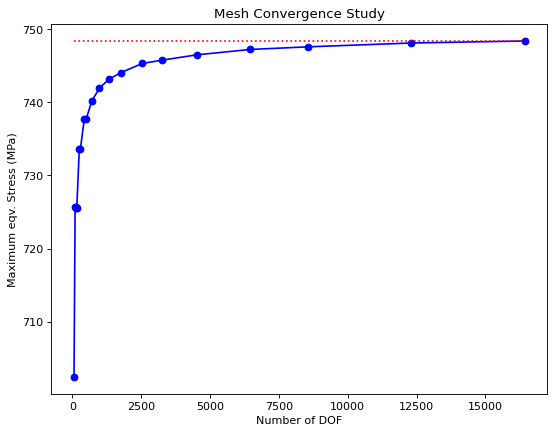

In [4]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(num_dof, max_stress, 'b-o')
plt.plot([num_dof[0], num_dof[-1]], [max_stress[-1], max_stress[-1]], 'r:')
plt.title('Mesh Convergence Study')
plt.xlabel('Number of DOF')
plt.ylabel('Maximum eqv. Stress (MPa)')
plt.show()

## Step 4 - Plot results from converged mesh analysis

In [5]:
# Plot the final mesh used
mapdl.allsel('ALL')
# mapdl.eplot(
#     title='Element Plot', line_width=1, show_bounds=True, cpos="xy"
# )

SELECT ALL ENTITIES OF TYPE= ALL  AND BELOW

#### Plot nodal displacement

In [6]:
# Enter post-processing (/POST1) and select the first load step
mapdl.post1()
mapdl.set(1, 1)

mapdl.post_processing.plot_nodal_displacement(
    'NORM', cpos="xy", cmap="magma",
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

#### Plot nodal equivalent stress

In [7]:
mapdl.post_processing.plot_nodal_eqv_stress(cpos="xy", cmap="magma")

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

#### Exit MAPDL

In [8]:
mapdl.exit()